**Runned on colab**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [85]:
from google.colab import files
uploaded = files.upload()

Saving Dataset Penyakit Kulit.zip to Dataset Penyakit Kulit (1).zip


In [3]:
!unzip -uq "/content/Dataset Penyakit Kulit.zip" -d "/content"

In [5]:
import tensorflow as tf
import tensorflow_hub as hub
import os
from keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.applications.densenet import DenseNet121

In [6]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.15.0


In [50]:
train_dir='/content/Dataset Penyakit Kulit'

In [51]:
Labels = ['Bisul', 'Cacar Air', 'Campak', 'Eksim', 'Herpes',
          'Jerawat', 'Kanker Kulit','Kudis', 'Kurap', 'Kusta',
          'Kutil', 'Melanoctyc', 'Molluscum', 'Panu']

In [52]:
print ("class : ")
for i in range(len(Labels)):
    print (i, end = " ")
    print (Labels[i])

class : 
0 Bisul
1 Cacar Air
2 Campak
3 Eksim
4 Herpes
5 Jerawat
6 Kanker Kulit
7 Kudis
8 Kurap
9 Kusta
10 Kutil
11 Melanoctyc
12 Molluscum
13 Panu


In [53]:
print('Number of classes:',len(Labels))

Number of classes: 14


In [54]:
module_selection = ("densenet", 224, 1280)
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
BATCH_SIZE = 32

In [55]:
IMAGE_SIZE

(224, 224)

In [56]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      vertical_flip=True,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      fill_mode='nearest',
      validation_split=0.2)

validation_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    subset="training",
    shuffle=True,
    seed=42,
    color_mode="rgb",
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    shuffle=False,
    seed=42,
    color_mode="rgb",
    class_mode="categorical",
    subset="validation",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

Found 672 images belonging to 14 classes.
Found 168 images belonging to 14 classes.


DenseNet121 🚀

In [57]:
dense121 =  DenseNet121(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), include_top=False, weights='imagenet')
new_model = dense121.output
new_model = tf.keras.layers.GlobalAveragePooling2D(name='globalavg')(new_model)
new_model = tf.keras.layers.Dense(512,activation='relu')(new_model) #dense layer 3
preds = tf.keras.layers.Dense(train_generator.num_classes, activation='softmax', name='output_layer_last')(new_model) #final layer with softmax activation
model = Model(inputs=dense121.input,outputs=preds)

model.build((None,) + IMAGE_SIZE + (3,))
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_4 (ZeroPadd  (None, 230, 230, 3)          0         ['input_3[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_4[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

In [58]:
for layer in model.layers:
        layer.trainable=True

In [59]:
LEARNING_RATE = 0.001
model.compile(
   optimizer=tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=0.9),
   loss='categorical_crossentropy',
   metrics=['accuracy'])

In [60]:
LEARNING_RATE = 0.001
model.compile(
   optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
   loss='categorical_crossentropy',
   metrics=['accuracy'])

In [61]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [62]:
EPOCHS=100
history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size,
        callbacks = learning_rate_reduction)

Epoch 1/100
21/21 [==============================] - 80s 949ms/step - loss: 2.3168 - accuracy: 0.2902 - val_loss: 6.8018 - val_accuracy: 0.0812 - lr: 0.0010
Epoch 2/100
21/21 [==============================] - 18s 874ms/step - loss: 1.8310 - accuracy: 0.4077 - val_loss: 7.7885 - val_accuracy: 0.0750 - lr: 0.0010
Epoch 3/100
21/21 [==============================] - 18s 882ms/step - loss: 1.4922 - accuracy: 0.5030 - val_loss: 5.8273 - val_accuracy: 0.1562 - lr: 0.0010
Epoch 4/100
21/21 [==============================] - 18s 833ms/step - loss: 1.3842 - accuracy: 0.5402 - val_loss: 5.6394 - val_accuracy: 0.1625 - lr: 0.0010
Epoch 5/100
21/21 [==============================] - 17s 833ms/step - loss: 1.1523 - accuracy: 0.6220 - val_loss: 5.0033 - val_accuracy: 0.1813 - lr: 0.0010
Epoch 6/100
21/21 [==============================] - 16s 749ms/step - loss: 1.0812 - accuracy: 0.6503 - val_loss: 4.1711 - val_accuracy: 0.2875 - lr: 0.0010
Epoch 7/100
21/21 [==============================] - 20s 9

In [63]:
valid_loss , valid_accuracy = model.evaluate_generator(validation_generator)
print("accuracy after transfer learning :{}".format(valid_accuracy))
# interpretation model
acc=history.history['accuracy']
val_acc =history.history['val_accuracy']
loss = history.history['loss']
val_loss= history.history['val_loss']

<ipython-input-63-68822de59708>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  valid_loss , valid_accuracy = model.evaluate_generator(validation_generator)


accuracy after transfer learning :0.6845238208770752


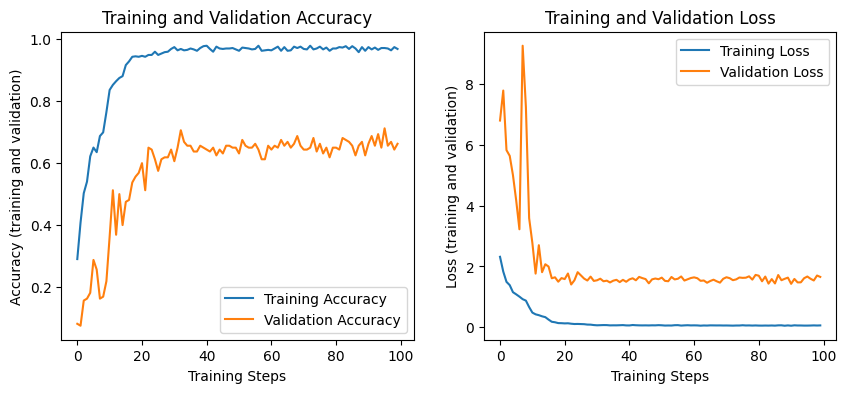

In [64]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

1/1 [==============================] - 2s 2s/step
class: Kudis, confidence: 0.630561


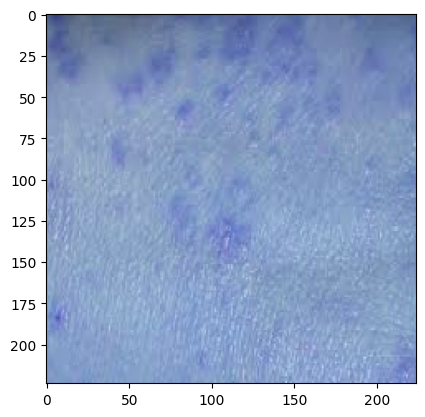

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 31ms/step
class: Kusta, confidence: 0.682290


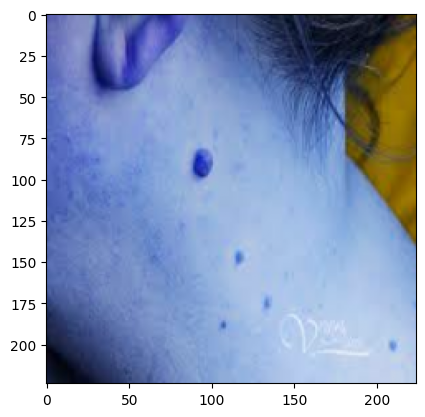

1/1 [==============================] - 0s 32ms/step
class: Melanoctyc, confidence: 0.943792


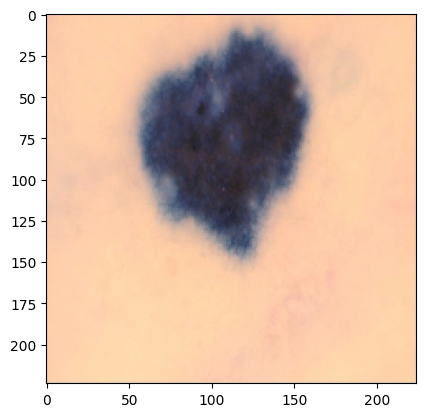

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 44ms/step
class: Kurap, confidence: 0.789587


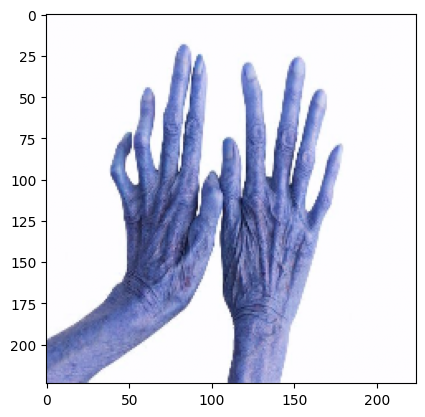

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 32ms/step
class: Kusta, confidence: 0.713653


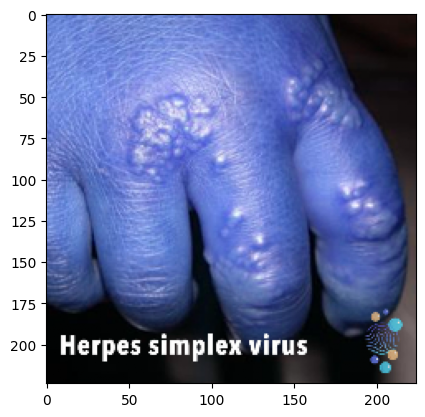

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 31ms/step
class: Kusta, confidence: 0.712483


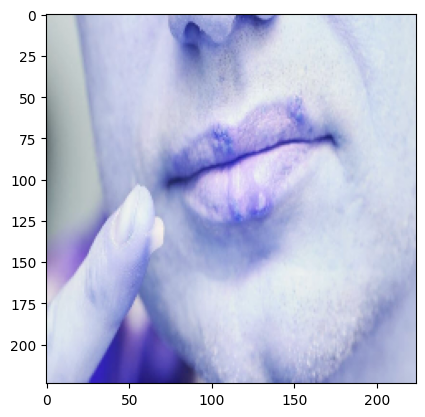

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 43ms/step
class: Kusta, confidence: 0.792169


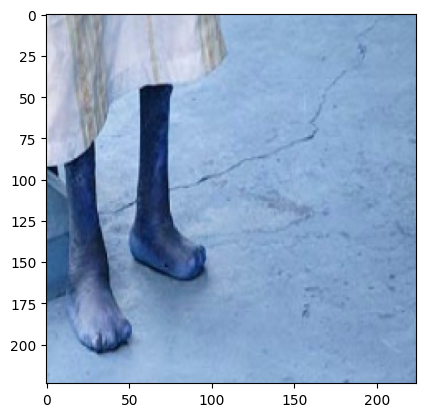

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 36ms/step
class: Kudis, confidence: 0.930364


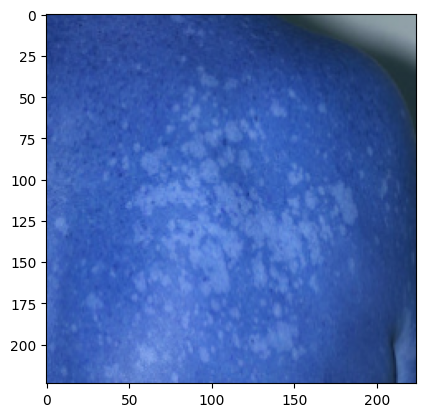

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 36ms/step
class: Melanoctyc, confidence: 0.877879


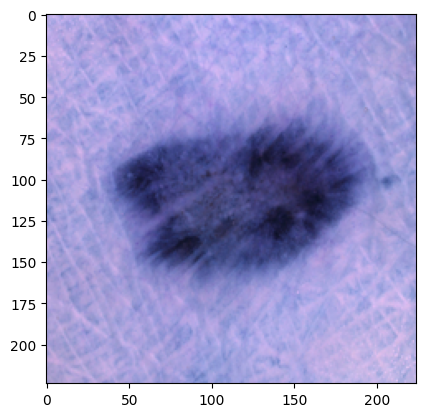

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 38ms/step
class: Kudis, confidence: 0.950384


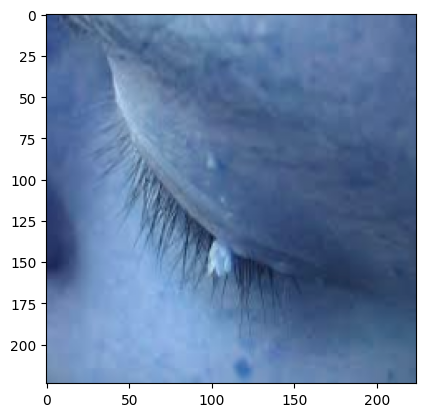

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 46ms/step
class: Kudis, confidence: 0.961484


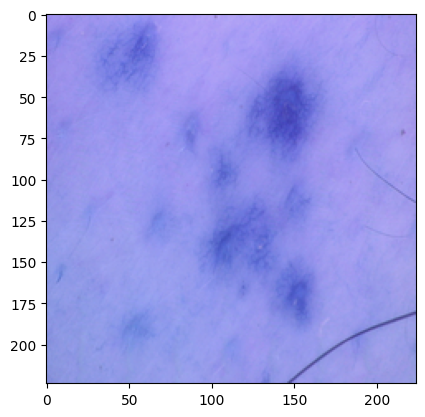

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 42ms/step
class: Kudis, confidence: 0.744125


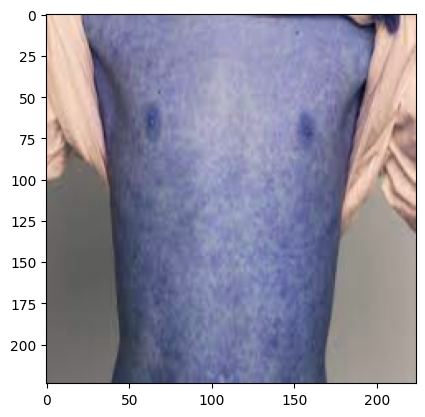

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 42ms/step
class: Kudis, confidence: 0.847928


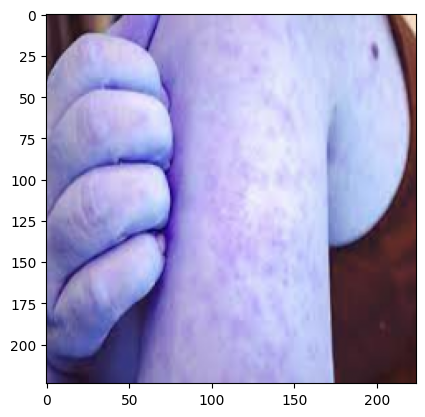

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 68ms/step
class: Kusta, confidence: 0.867930


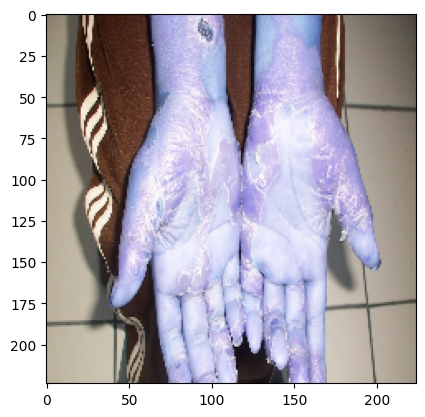

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 66ms/step
class: Panu, confidence: 0.845529


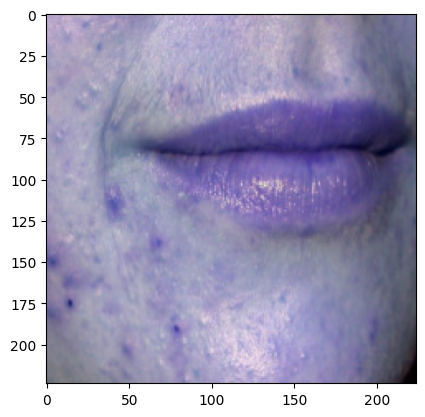

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 75ms/step
class: Kudis, confidence: 0.976588


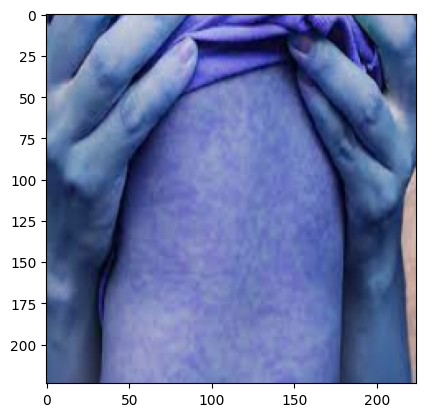

<Figure size 640x480 with 0 Axes>

In [65]:
import random
import cv2
def upload(filename):
    img = cv2.imread(os.path.join(train_dir, filename))
    img = cv2.resize(img, (224, 224) )
    img = img /255

    return img

def pre_result(image):
    x = model.predict(np.asarray([img]))[0]
    classx = np.argmax(x)

    return {Labels[classx]: x[classx]}

images = random.sample(validation_generator.filenames, 16)

for idx, filename in enumerate(images):
    img = upload(filename)
    prediction = pre_result(img)
    print("class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)
    plt.show()

In [66]:
from sklearn.metrics import classification_report, confusion_matrix
predictions1 = model.predict(validation_generator, steps=len(validation_generator))
y = np.argmax(predictions1, axis=1)

print('Classification Report')
cr = classification_report(y_true=validation_generator.classes, y_pred=y, target_names=validation_generator.class_indices)
print(cr)

evaluates = model.evaluate(validation_generator)

print(evaluates)

6/6 [==============================] - 8s 553ms/step
Classification Report
              precision    recall  f1-score   support

       Bisul       0.82      0.75      0.78        12
   Cacar Air       0.90      0.75      0.82        12
      Campak       0.62      0.67      0.64        12
       Eksim       0.53      0.67      0.59        12
      Herpes       0.50      0.75      0.60        12
     Jerawat       0.67      0.83      0.74        12
Kanker Kulit       0.71      1.00      0.83        12
       Kudis       0.33      0.50      0.40        12
       Kurap       0.50      0.25      0.33        12
       Kusta       0.71      0.83      0.77        12
       Kutil       0.71      0.42      0.53        12
  Melanoctyc       0.89      0.67      0.76        12
   Molluscum       0.80      0.33      0.47        12
        Panu       0.70      0.58      0.64        12

    accuracy                           0.64       168
   macro avg       0.67      0.64      0.64       168
weigh

Confusion Matrix


<Axes: >

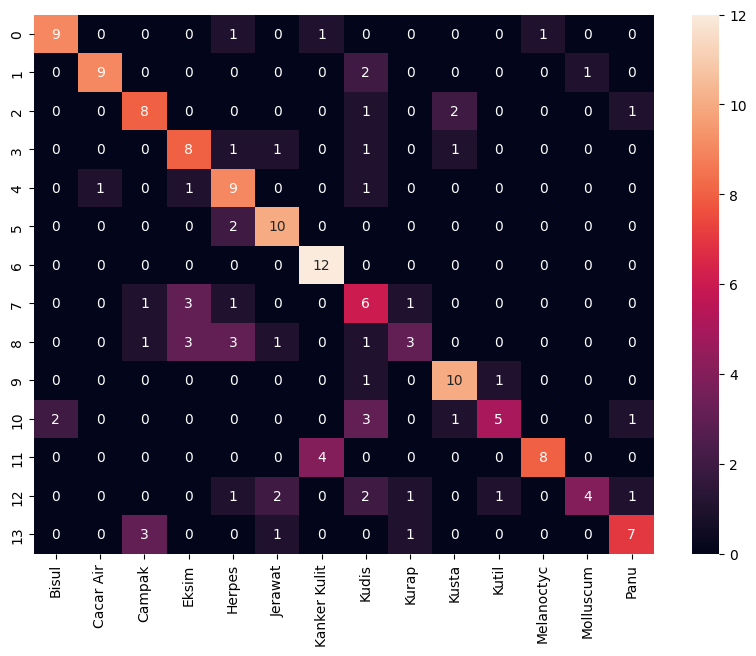

In [67]:
import pandas as pd
import numpy as np
import seaborn as sn
print('Confusion Matrix')
cm = confusion_matrix(validation_generator.classes, y)
df = pd.DataFrame(cm, columns=validation_generator.class_indices)
plt.figure(figsize=(10,7))
sn.heatmap(df, annot=True)

In [68]:
cd /content

/content


#Export as saved model and convert to TFLite

In [69]:
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
tf.keras.models.save_model(model, export_path)

export_path

'/tmp/saved_models/1717944815'

In [70]:
# Now confirm that we can reload it, and it still gives the same results
reloaded = tf.keras.models.load_model(export_path, custom_objects={'KerasLayer':hub.KerasLayer})

In [71]:
def predict_reload(image):
    probabilities = reloaded.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)

    return {Labels[class_idx]: probabilities[class_idx]}

SOURCE: class: Bisul, file: Bisul/Image_18.jpg
1/1 [==============================] - 0s 49ms/step
PREDICTED: class: Bisul, confidence: 0.859824


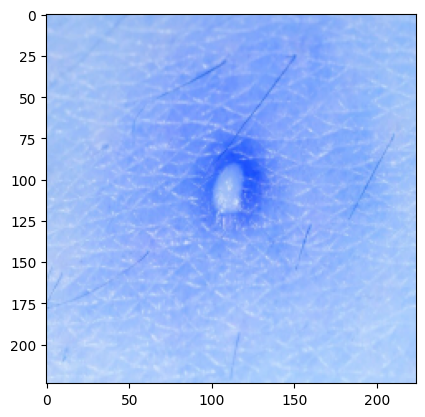

<Figure size 640x480 with 0 Axes>

SOURCE: class: Kutil, file: Kutil/Image_4.jpg
1/1 [==============================] - 0s 54ms/step
PREDICTED: class: Kudis, confidence: 0.609571


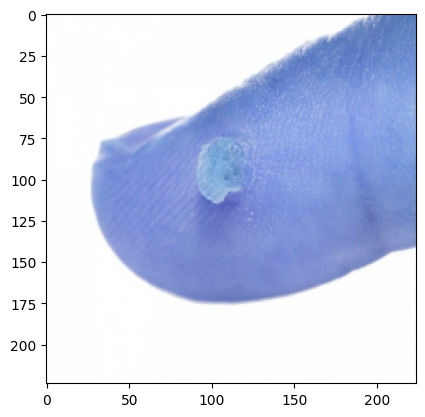

In [80]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 2)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))

    img = upload(filename)
    prediction = predict_reload(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)
    plt.show()

In [81]:
# convert the model to TFLite
!mkdir "tflite_models"
TFLITE_MODEL = "tflite_models/model.tflite"


# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : reloaded(x))

# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)

# Convert the model to standard TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

mkdir: cannot create directory ‘tflite_models’: File exists


30018168

Convert to json

In [82]:
from tensorflow.keras.models import load_model

# Assuming 'model' is your trained model
model.save('my_model.h5')

# To load the model back, you can use:
loaded_model = load_model('my_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
!pip install tensorflowjs

In [83]:
!tensorflowjs_converter --input_format=keras --output_format=tfjs_layers_model /content/my_model.h5 /content

/bin/bash: line 1: tensorflowjs_converter: command not found
